# Image Quality Metrics for Synthetic HX4-PET Evaulation

Two broad types of metrics:
1. Voxel-wise differences: MSE, MAE, PSNR
2. Statistical measures: SSIM, Mutual Information, Histogram chi-square distance

In [67]:
import time

import numpy as np
import pandas as pd
from scipy.stats import entropy
from skimage.metrics import (mean_squared_error,
                             peak_signal_noise_ratio,
                             structural_similarity)

import SimpleITK as sitk

## Metric functions and utils

In [68]:
def mse(predicted, ground_truth):
    mse_value = mean_squared_error(predicted, ground_truth)
    return float(mse_value)

def mae(predicted, ground_truth):
    mae_value = np.absolute(predicted - ground_truth).mean()
    return float(mae_value)


def psnr(predicted, ground_truth, data_range):
    psnr_value = peak_signal_noise_ratio(predicted, 
                                         ground_truth, 
                                         data_range=data_range)
    return float(psnr_value)

def ssim(predicted, ground_truth, data_range):
    ssim_value = structural_similarity(predicted, 
                                       ground_truth, 
                                       data_range=data_range)
    return float(ssim_value)

def nmi(predicted, ground_truth, bins=100):
    """Normalized Mutual Information.
    Implementation taken from scikit-image 0.19.0.dev0 source.
    """
    hist, bin_edges = np.histogramdd(
            [np.reshape(predicted, -1), np.reshape(ground_truth, -1)],
            bins=bins,
            density=True,
            )
    H0 = entropy(np.sum(hist, axis=0))
    H1 = entropy(np.sum(hist, axis=1))
    H01 = entropy(np.reshape(hist, -1))
    nmi_value = (H0 + H1) / H01
    return float(nmi_value)


def chi_squared_histogram_distance(predicted, ground_truth, bins=100):
    pred_histogram, pred_bin_edges = np.histogram(predicted, bins=bins)
    gt_histogram, gt_bin_edges = np.histogram(ground_truth, bins=bins)
    
    # Normalize the histograms to make them discrete distributions
    pred_histogram = pred_histogram / pred_histogram.sum()
    gt_histogram = gt_histogram / gt_histogram.sum()
    
    # Compute chi-squared distance
    chi_sq_dist_value = np.sum((pred_histogram - gt_histogram)**2 / (pred_histogram + gt_histogram))
    return float(chi_sq_dist_value)

## Run

In [69]:
SAMPLE_PATIENT = "N010"

PREDICTED_IMAGE_PATH = "../sample_nrrds/pix2pix_pred-N010.nrrd"
GROUND_TRUTH_IMAGE_PATH = "../sample_nrrds/hx4_pet_reg-N010.nrrd"

SUV_MEAN_AORTA_FILE = "/home/chinmay/Datasets/HX4-PET-Translation/SUVmean_aorta_HX4.csv"
HX4_TBR_MIN, HX4_TBR_MAX = 0.0, 3.0

### Read images and preprocess

In [70]:
# Read images 

predicted = sitk.ReadImage(PREDICTED_IMAGE_PATH)
ground_truth = sitk.ReadImage(GROUND_TRUTH_IMAGE_PATH)

predicted = sitk.GetArrayFromImage(predicted)
ground_truth = sitk.GetArrayFromImage(ground_truth)

suv_aorta_mean_values = pd.read_csv(SUV_MEAN_AORTA_FILE, index_col=0)
suv_aorta_mean_values = suv_aorta_mean_values.to_dict()['HX4 aorta SUVmean baseline']
suv_aorta_mean = suv_aorta_mean_values[SAMPLE_PATIENT]

print(predicted.shape)
print(ground_truth.shape)
print(suv_aorta_mean)

(40, 500, 500)
(40, 500, 500)
0.6976219351999999


In [71]:
# Normalize with SUVmean_aorta
predicted = predicted / suv_aorta_mean
ground_truth = ground_truth / suv_aorta_mean

# Cap the range
predicted = np.clip(predicted, HX4_TBR_MIN, HX4_TBR_MAX)
ground_truth = np.clip(ground_truth, HX4_TBR_MIN, HX4_TBR_MAX)

### Compute metrics and measure runtime

In [72]:
# MSE

t1 = time.perf_counter()
mse_value = mse(predicted, ground_truth)
t2 = time.perf_counter()

print("MSE:", mse_value)
print(f"Run time (sec): {t2-t1:0.4f}")

MSE: 0.006613276351601681
Run time (sec): 0.0667


In [73]:
# MAE

t1 = time.perf_counter()
mae_value = mse(predicted, ground_truth)
t2 = time.perf_counter()

print("MAE:", mae_value)
print(f"Run time (sec): {t2-t1:0.4f}")

MAE: 0.006613276351601681
Run time (sec): 0.0772


In [74]:
# PSNR

t1 = time.perf_counter()
psnr_value = psnr(predicted, ground_truth, data_range=HX4_TBR_MAX - HX4_TBR_MIN)
t2 = time.perf_counter()

print("PSNR:", psnr_value)
print(f"Run time (sec): {t2-t1:0.4f}")

PSNR: 31.338258383203996
Run time (sec): 0.0751


In [75]:
# SSIM

t1 = time.perf_counter()
ssim_value = ssim(predicted, ground_truth, data_range=HX4_TBR_MAX - HX4_TBR_MIN)
t2 = time.perf_counter()

print("SSIM:", ssim_value)
print(f"Run time (sec): {t2-t1:0.4f}")

SSIM: 0.5979957576998051
Run time (sec): 8.5806


In [76]:
# Normalized Mutual Information

t1 = time.perf_counter()
nmi_value = nmi(predicted, ground_truth)
t2 = time.perf_counter()

print("NMI:", nmi_value)
print(f"Run time (sec): {t2-t1:0.4f}")

NMI: 1.201640645681537
Run time (sec): 2.4528


In [77]:
# Chi-squared Histogram Distance

t1 = time.perf_counter()
chi_sq_dist_value = chi_squared_histogram_distance(predicted, ground_truth)
t2 = time.perf_counter()

print("Chi-squared distance:", chi_sq_dist_value)
print(f"Run time (sec): {t2-t1:0.4f}")

Chi-squared distance: 0.5218886594237994
Run time (sec): 0.6806


In [95]:
import matplotlib.pyplot as plt

img_1 = ground_truth
img_2 = HX4_TBR_MAX - ground_truth

hist_1, _ = np.histogram(img_1, bins=100)
hist_2, _ = np.histogram(img_2, bins=100) 

chi_sq_value = chi_squared_histogram_distance(img_1, img_2)
print(chi_sq_value)

1.8830956950822086


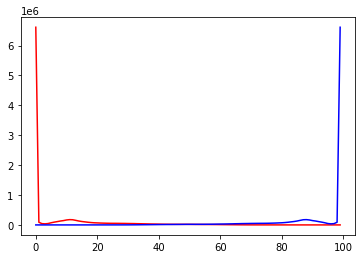

In [89]:
plt.plot(hist_1, 'r', label='img1 hist')
plt.plot(hist_2, 'b', label='img2 hist')
plt.show()